# Admission Level

The dataset is imported into my local postgres SQL database in it's original form. I used SQL to do most of the data cleaning and created some new variables. You may refer to sql.sql for the code.

**New Variables**

* Length of Stay (los)
* Age at admission (age_at_adm)
* Age categorised in bins (age_grp)
* BMI
* BMI Risk
* Total number of medical history (no_med_hist)
* Total number of symptoms (no_sym)
* Total number of pre-op medications (no_meds) 
* Total Bill (tot_bill)

**Data Clean-up**

* Converted categorical features into numerical codes
* Standardised the data type
* Impute null values

Total number of data = 3,400 (per row per admission)

In [10]:
# import packages

import psycopg2
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Processing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# display options

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth',200)

In [11]:
# connect to database

engine = psycopg2.connect("dbname=holmusk user=joannasyeow")
f = open("codes/sql.sql", "r")
sql = f.read()
df = pd.read_sql(sql, con=engine)

In [12]:
# have a quick look at our data

df.head()

,id_,patient_id,gender_c,resident_status_c,race_c,age_at_adm,age_grp,los,medical_history_1,medical_history_2_c,medical_history_3_c,medical_history_4,medical_history_5_c,medical_history_6,medical_history_7,no_med_hist,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,no_meds,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,no_sym,lab_result_1,lab_result_2,lab_result_3,weight,height,bmi,bmi_risk_c,tot_bill
0,8461069832,00225710a878eff524a1d13be817e8e2,1,0,2,31,0,12,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,13.4,27.9,96.0,66.9,155.0,27.85,4,5190.57
1,5621737529,0029d90eb654699c18001c17efb0f129,1,0,2,69,1,13,0,1,0,0,0,1,0,2,0,0,0,0,1,0,1,0,1,0,0,1,2,16.7,26.5,109.0,89.1,160.0,34.80,4,22601.50
2,9921582850,0040333abd68527ecb53e1db9073f52e,0,0,1,41,0,12,0,1,0,0,0,0,1,2,0,0,1,1,1,0,3,0,1,0,0,1,2,14.8,25.2,96.0,79.5,172.0,26.87,3,17447.18
3,7239419545,00473b58e3dc8ae37b3cb34069705083,1,0,2,38,0,5,1,0,0,0,0,0,0,1,0,0,1,1,1,0,3,0,1,1,1,0,3,14.9,28.7,122.0,81.1,160.0,31.68,4,15285.88
4,9476531069,0078662d1d983dde68ea057c42d5b5cf,0,2,3,70,1,12,0,1,0,0,0,1,0,2,1,0,1,1,1,0,4,0,1,0,1,1,3,14.2,27.2,89.0,74.7,173.0,24.96,3,73477.87


In [13]:
df.describe()

,id_,gender_c,resident_status_c,race_c,age_at_adm,age_grp,los,medical_history_1,medical_history_2_c,medical_history_3_c,medical_history_4,medical_history_5_c,medical_history_6,medical_history_7,no_med_hist,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,no_meds,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,no_sym,lab_result_1,lab_result_2,lab_result_3,weight,height,bmi,bmi_risk_c,tot_bill
count,3.400000e+03,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,8.004280e+09,0.500588,0.246176,2.214412,52.542647,0.416471,11.051176,0.169118,0.290000,0.136176,0.052059,0.058235,0.254706,0.254412,1.214706,0.503824,0.591176,0.820882,0.523235,0.819706,0.744118,4.002941,0.619706,0.662353,0.544706,0.726471,0.526765,3.080000,14.469882,27.431529,99.489706,78.748441,165.084412,28.958947,3.554412,21859.071256
std,1.610701e+09,0.500073,0.529492,0.691795,14.681475,0.493046,2.850140,0.374911,0.453829,0.343026,0.222178,0.234222,0.435760,0.435594,0.971992,0.500059,0.491689,0.383507,0.499533,0.384489,0.436420,1.106823,0.485530,0.472977,0.498071,0.445836,0.499357,1.068724,1.747323,2.463844,15.254453,10.975076,6.973678,4.140672,0.643142,10155.336729
min,1.350319e+09,0.000000,0.000000,1.000000,22.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,19.700000,52.000000,48.000000,151.000000,17.510000,1.000000,2946.100000
25%,7.094585e+09,0.000000,0.000000,2.000000,40.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,13.200000,25.800000,88.000000,71.200000,160.000000,26.160000,3.000000,14793.372500
50%,8.370572e+09,1.000000,0.000000,2.000000,51.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,14.500000,27.400000,100.000000,78.900000,165.000000,28.940000,4.000000,20180.020000
75%,9.293090e+09,1.000000,0.000000,3.000000,65.000000,1.000000,13.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,15.800000,29.100000,110.000000,86.300000,170.000000,31.712500,4.000000,26680.295000
max,9.999633e+09,1.000000,2.000000,4.000000,85.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,20.300000,35.100000,150.000000,121.000000,186.000000,46.680000,4.000000,98723.850000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 37 columns):
id_                    3400 non-null int64
patient_id             3400 non-null object
gender_c               3400 non-null int64
resident_status_c      3400 non-null int64
race_c                 3400 non-null int64
age_at_adm             3400 non-null int64
age_grp                3400 non-null int64
los                    3400 non-null int64
medical_history_1      3400 non-null int64
medical_history_2_c    3400 non-null int64
medical_history_3_c    3400 non-null int64
medical_history_4      3400 non-null int64
medical_history_5_c    3400 non-null int64
medical_history_6      3400 non-null int64
medical_history_7      3400 non-null int64
no_med_hist            3400 non-null int64
preop_medication_1     3400 non-null int64
preop_medication_2     3400 non-null int64
preop_medication_3     3400 non-null int64
preop_medication_4     3400 non-null int64
preop_medication_5     3400 non-

In [15]:
# check for duplicated rows

len(df.loc[df.duplicated(), :])

0

Great ! Seems like data is all cleaned up from SQL end.

## Variable Analysis

In this part of the workbook, i'll be using some visualisation and statstical models to look into our data

** Target Variable **

The distribution of the data is highly skewed to the right. A natural log is applied to the data to ensure approximate normality.

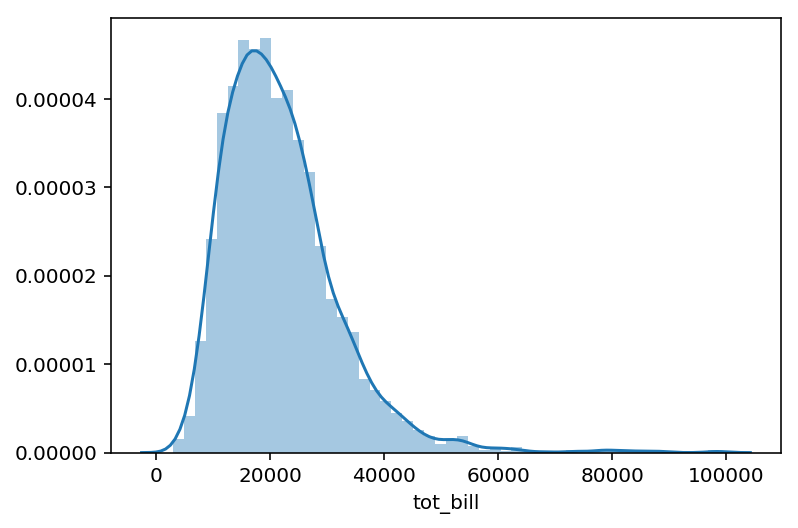

p-value (Sharpiro-Wilk Test):  7.132609183413319e-43


In [16]:
# Sharpiro-Wilk Test for Normality

sns.distplot(df['tot_bill'])
plt.show()
print ('p-value (Sharpiro-Wilk Test): ',stats.shapiro(df['tot_bill'])[1])

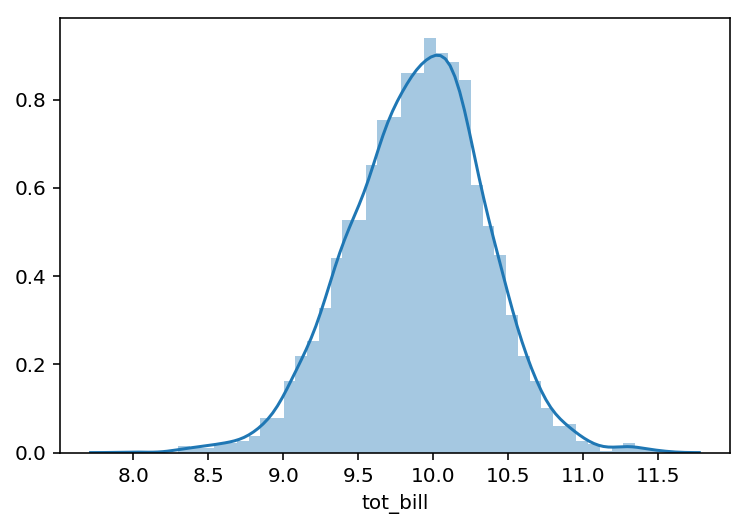

p-value (Sharpiro-Wilk Test):  2.660954805833171e-06


In [17]:
# Sharpiro-Wilk Test for Normality

sns.distplot(np.log(df['tot_bill']))
plt.show()
print ('p-value (Sharpiro-Wilk Test): ',stats.shapiro(np.log(df['tot_bill']))[1])


Now that looks better !

In [18]:
# create new target variable
df['log_bill'] = np.log(df['tot_bill'])

# Symptoms Analysis

** Symptoms 1 to 5 **

A deep dive to have a look at how symptoms impacts the cost of care in an admission

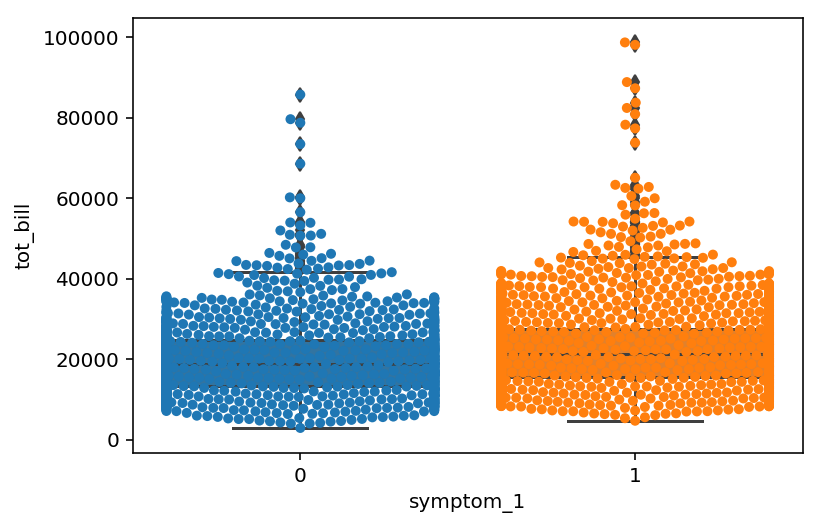

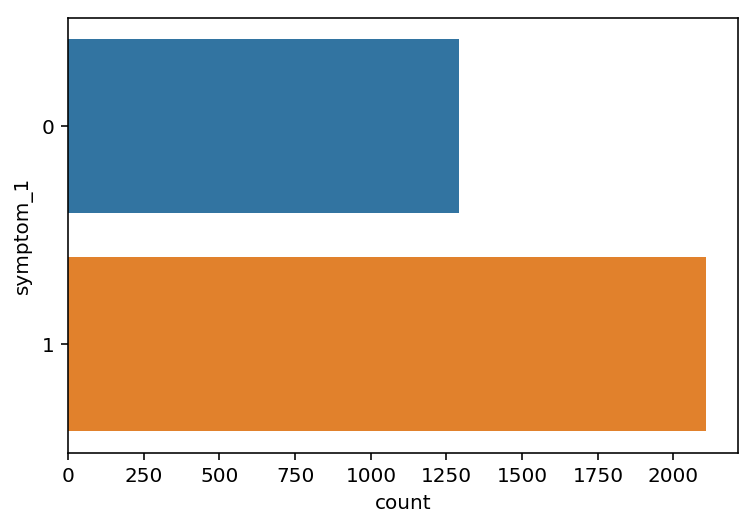


Value Count:
symptom_1
0    1233
1    1955
Name: patient_id, dtype: int64

Mean Total Bills:
symptom_1
0    20195.861237
1    22879.731224
Name: tot_bill, dtype: float64



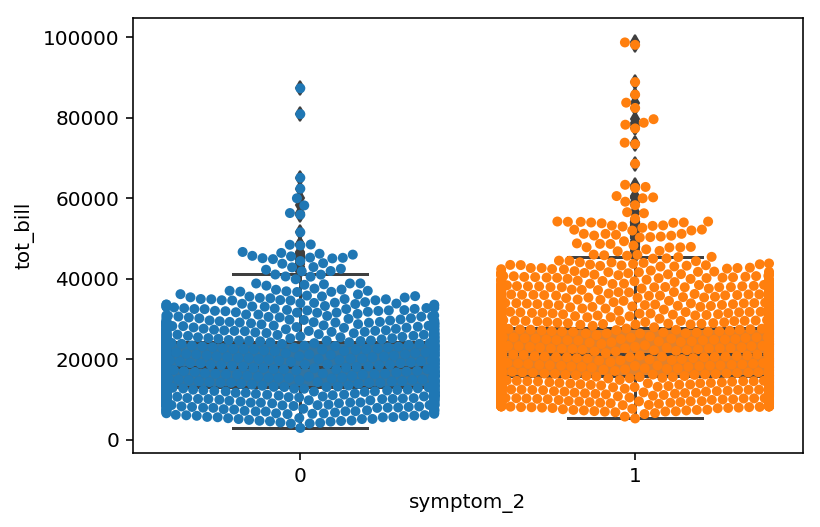

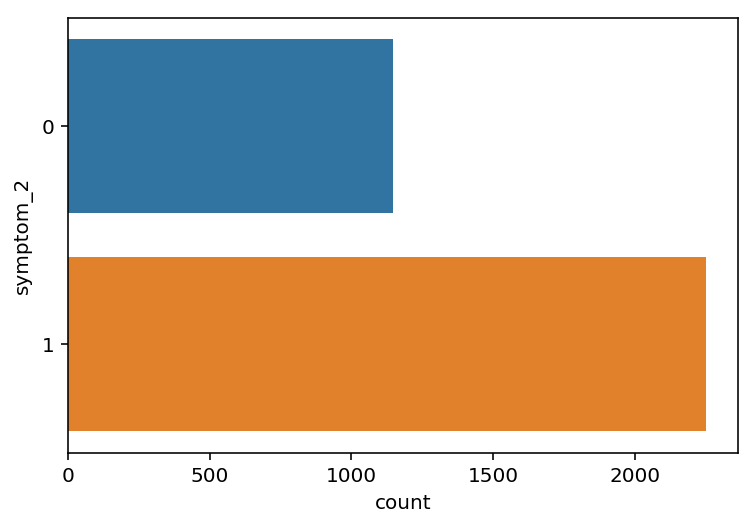


Value Count:
symptom_2
0    1097
1    2062
Name: patient_id, dtype: int64

Mean Total Bills:
symptom_2
0    19614.659329
1    23003.203091
Name: tot_bill, dtype: float64



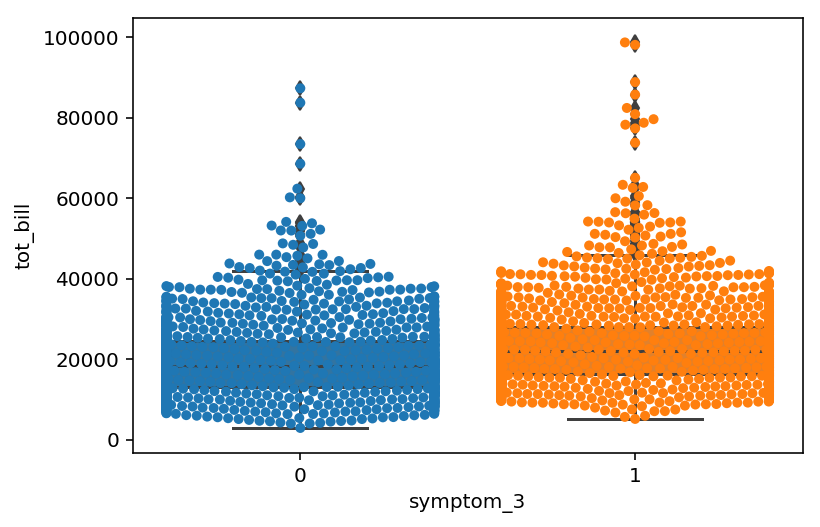

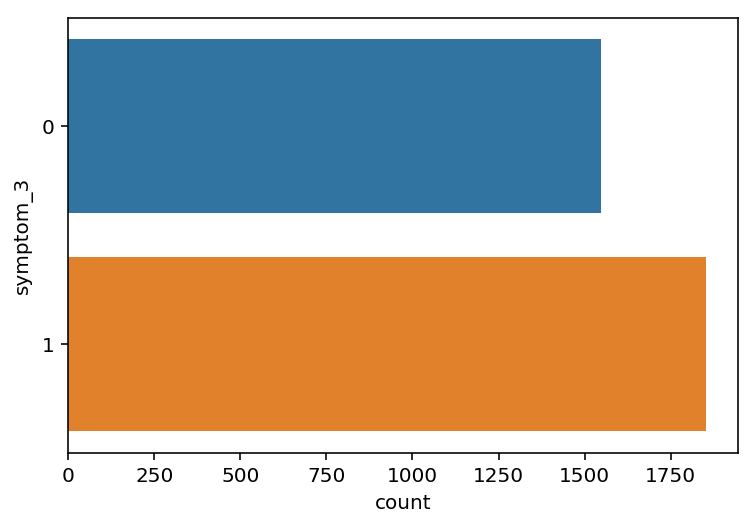


Value Count:
symptom_3
0    1461
1    1740
Name: patient_id, dtype: int64

Mean Total Bills:
symptom_3
0    19815.665336
1    23567.058494
Name: tot_bill, dtype: float64



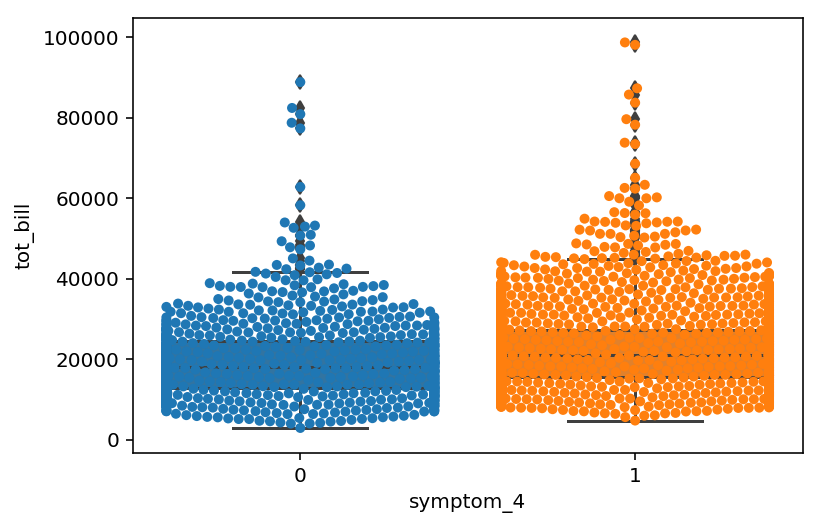

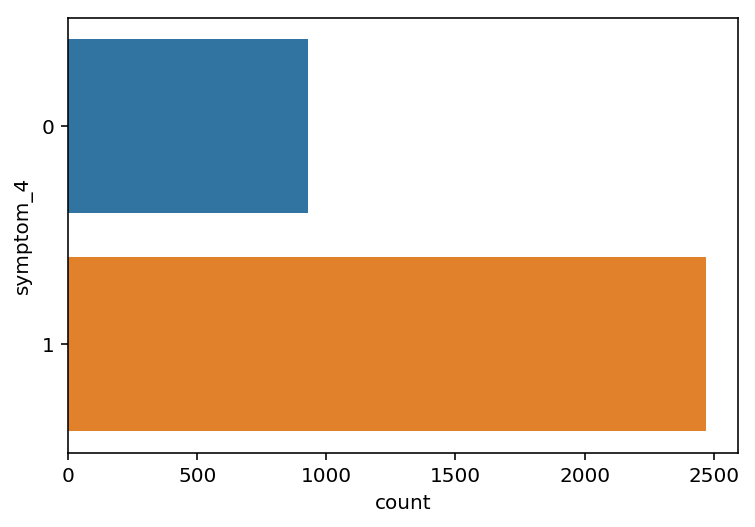


Value Count:
symptom_4
0     901
1    2237
Name: patient_id, dtype: int64

Mean Total Bills:
symptom_4
0    19703.961323
1    22670.509409
Name: tot_bill, dtype: float64



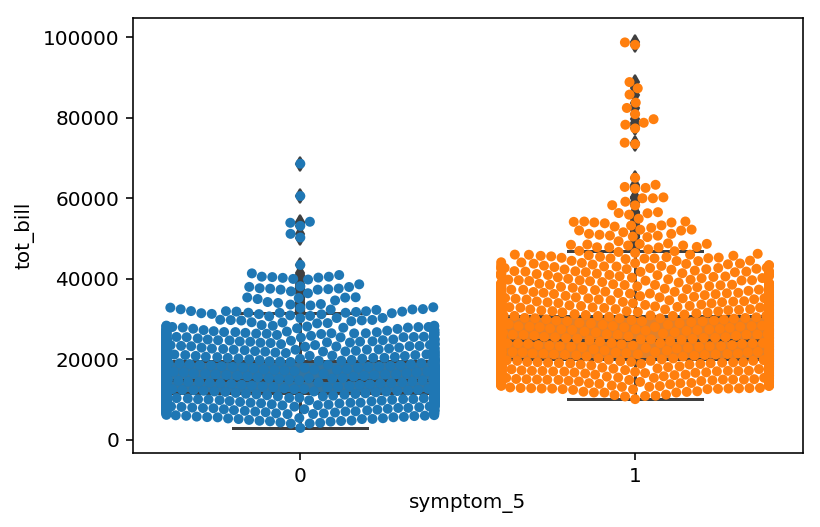

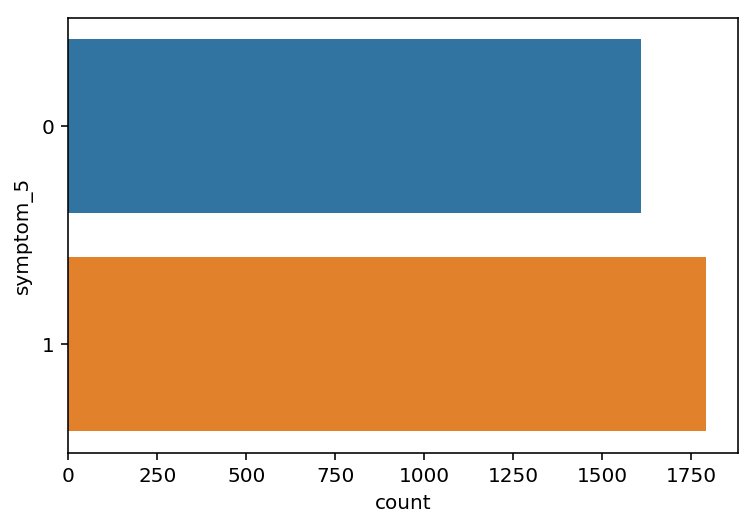


Value Count:
symptom_5
0    1517
1    1676
Name: patient_id, dtype: int64

Mean Total Bills:
symptom_5
0    16322.843779
1    26832.711686
Name: tot_bill, dtype: float64



In [21]:
# descriptive analysis for symptoms data

for c in range(1,6): 
        sns.boxplot(y=df['tot_bill'],x=df['symptom_'+str(c)])
        sns.swarmplot(y=df['tot_bill'],x=df['symptom_'+str(c)])
        plt.show()
        sns.countplot(y = df['symptom_'+str(c)])
        plt.show()
        print()
        print('Value Count:')
        print(df.groupby('symptom_'+str(c))['patient_id'].nunique())
        print()
        print('Mean Total Bills:')
        print(df.groupby('symptom_'+str(c))['tot_bill'].mean())
        print()
#         print('Mean Average Bills:')
#         print (df.groupby(c)['avg_bill'].mean())
#         print()

** One-way ANOVA ** on demographics variables

In [23]:
# symptoms

for c in range(1,6): 
    print()
    print('-------')
    print('symptom_'+str(c))
    print('-------')
    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['symptom_'+str(c)] == 1]['log_bill'], df[df['symptom_'+str(c)] == 0]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


-------
symptom_1
-------
F: 82.83957498037284
P-value:  1.4801748876316555e-19
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

-------
symptom_2
-------
F: 119.07991812699424
P-value:  2.8365452273614362e-27
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

-------
symptom_3
-------
F: 168.42529616121624
P-value:  1.262095637893431e-37
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

-------
symptom_4
-------
F: 100.26239465978303
P-value:  2.7973349711035935e-23
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

-------
symptom_5
-------
F: 1732.657480730986
P-value:  2.16

# Pre-Op Medications Analysis

** preop_medication_1 to 6 **

A deep dive to have a look at how pre-op medications impacts the cost of care in an admission

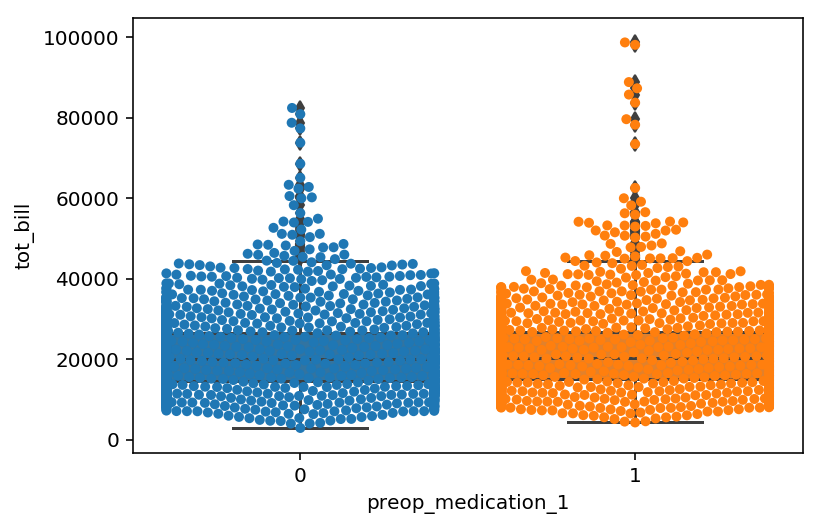

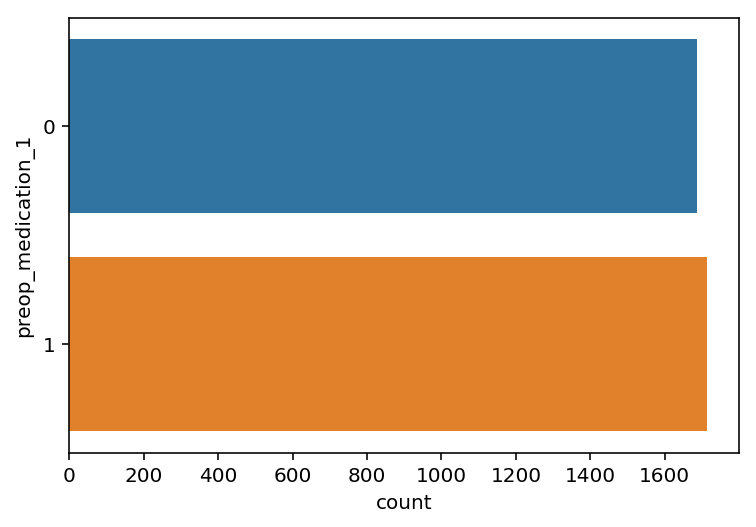


Value Count:
preop_medication_1
0    1597
1    1606
Name: patient_id, dtype: int64

Mean Total Bills:
preop_medication_1
0    21694.215673
1    22021.424653
Name: tot_bill, dtype: float64



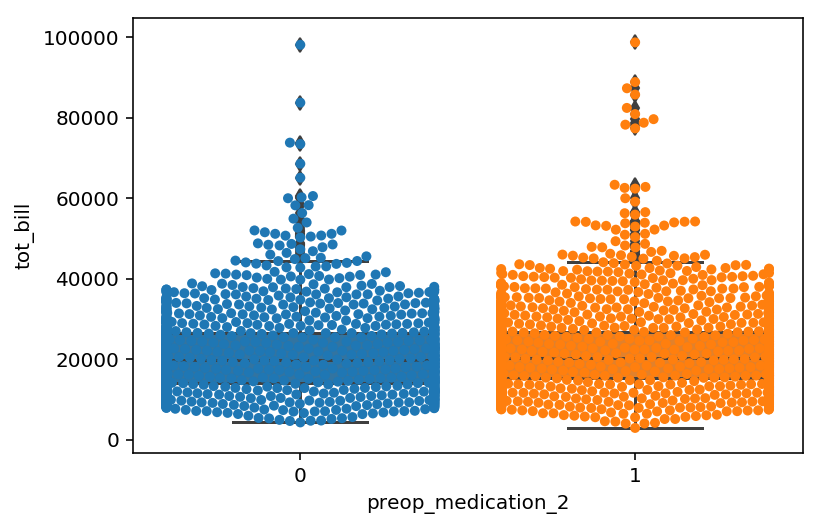

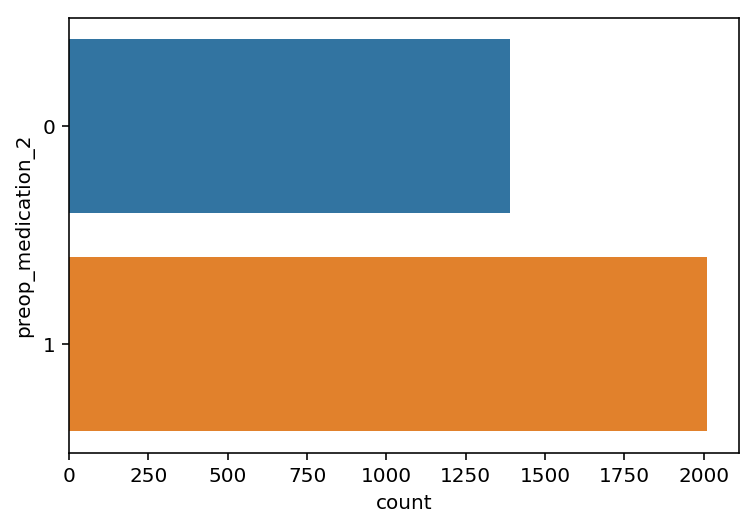


Value Count:
preop_medication_2
0    1332
1    1867
Name: patient_id, dtype: int64

Mean Total Bills:
preop_medication_2
0    21465.139640
1    22131.491627
Name: tot_bill, dtype: float64



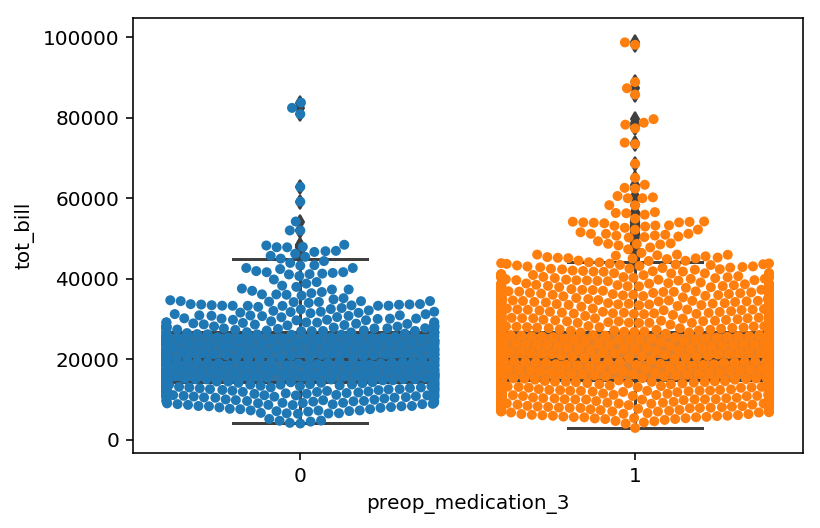

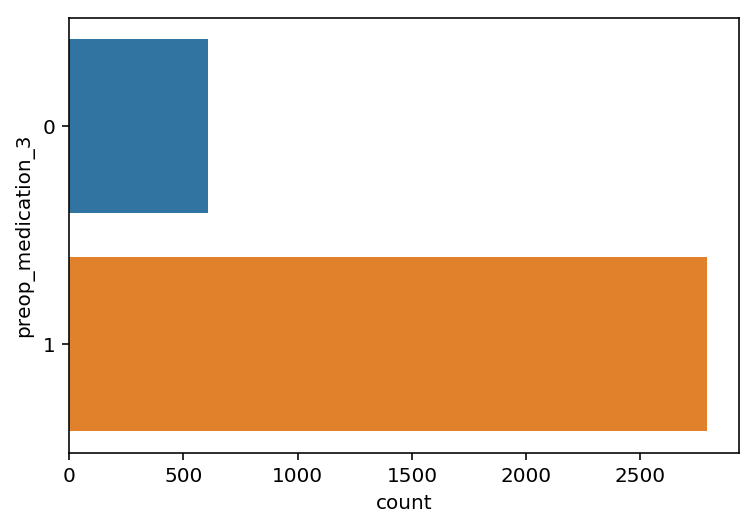


Value Count:
preop_medication_3
0     595
1    2524
Name: patient_id, dtype: int64

Mean Total Bills:
preop_medication_3
0    21688.672102
1    21896.252583
Name: tot_bill, dtype: float64



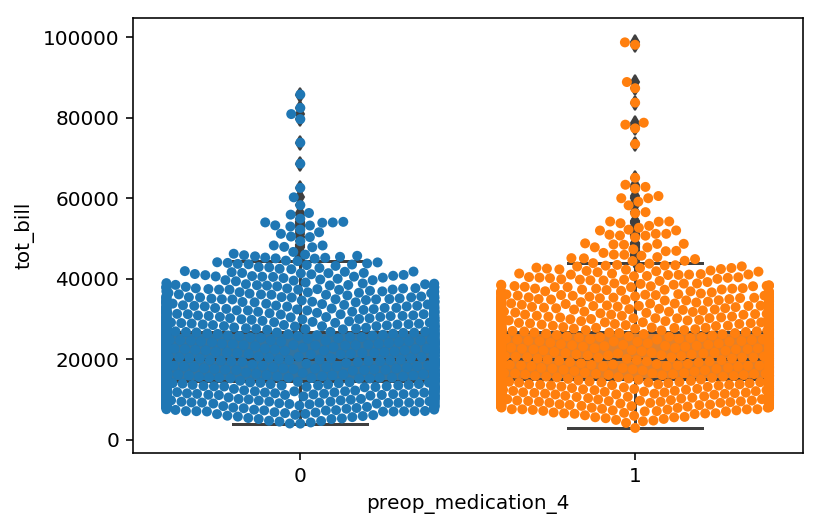

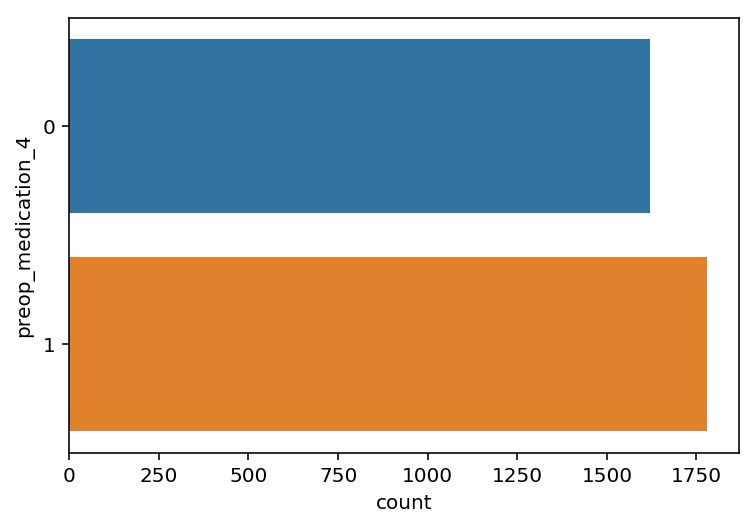


Value Count:
preop_medication_4
0    1535
1    1663
Name: patient_id, dtype: int64

Mean Total Bills:
preop_medication_4
0    21697.431123
1    22006.355492
Name: tot_bill, dtype: float64



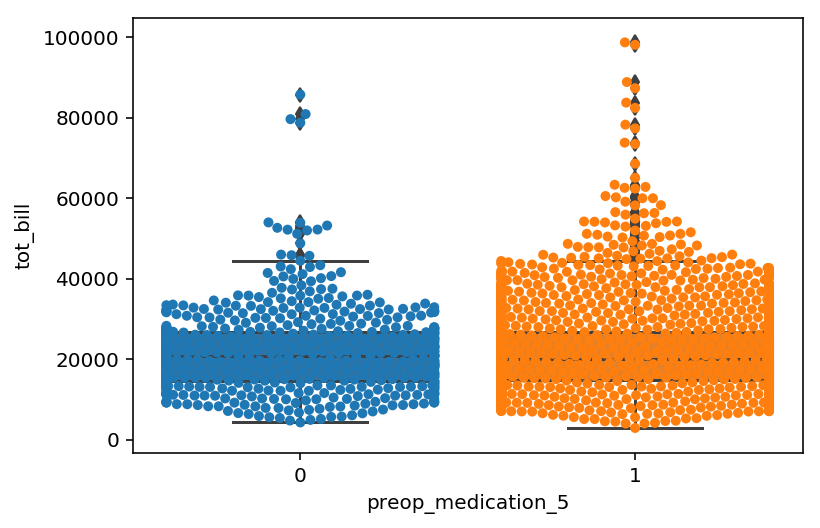

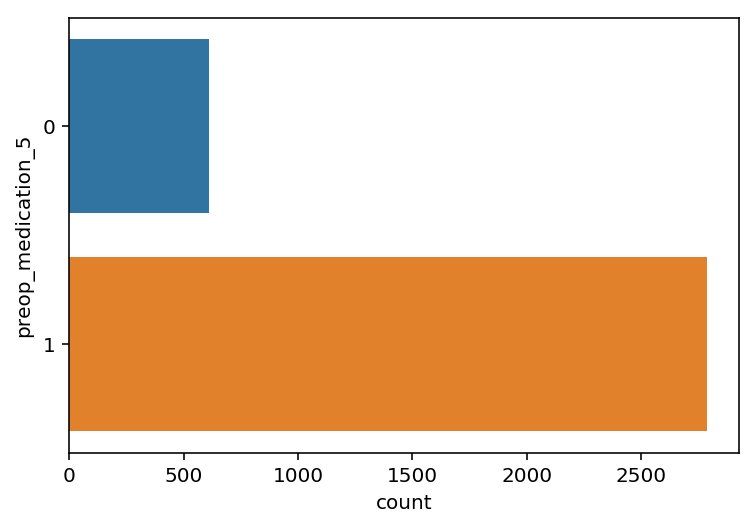


Value Count:
preop_medication_5
0     601
1    2524
Name: patient_id, dtype: int64

Mean Total Bills:
preop_medication_5
0    21849.265285
1    21861.228077
Name: tot_bill, dtype: float64



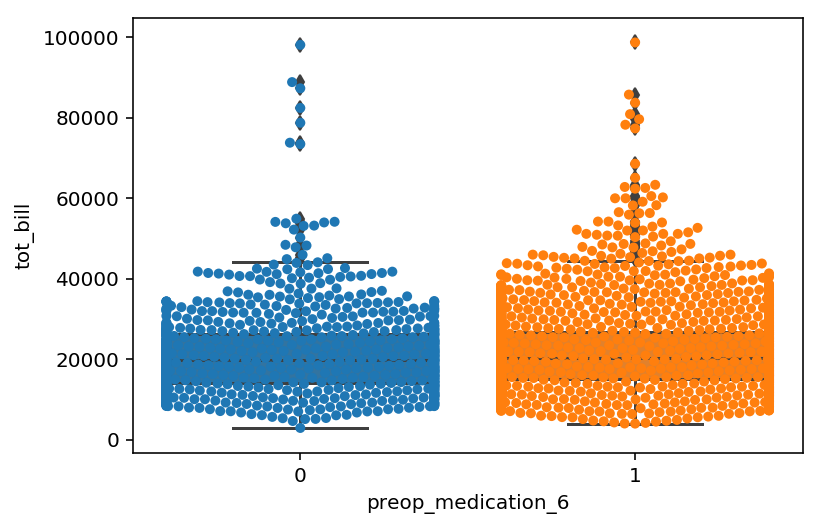

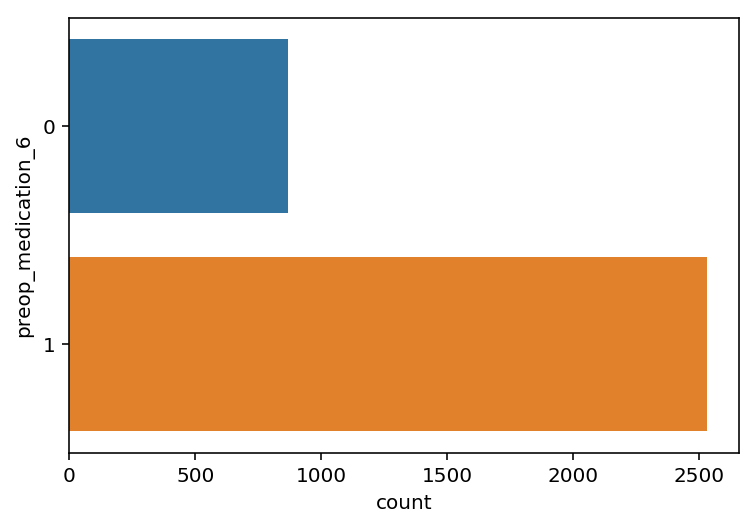


Value Count:
preop_medication_6
0     850
1    2291
Name: patient_id, dtype: int64

Mean Total Bills:
preop_medication_6
0    21484.959563
1    21987.718360
Name: tot_bill, dtype: float64



In [24]:
# descriptive analysis for pre-op medications data

for c in range(1,7): 
        sns.boxplot(y=df['tot_bill'],x=df['preop_medication_'+str(c)])
        sns.swarmplot(y=df['tot_bill'],x=df['preop_medication_'+str(c)])
        plt.show()
        sns.countplot(y = df['preop_medication_'+str(c)])
        plt.show()
        print()
        print('Value Count:')
        print(df.groupby('preop_medication_'+str(c))['patient_id'].nunique())
        print()
        print('Mean Total Bills:')
        print(df.groupby('preop_medication_'+str(c))['tot_bill'].mean())
        print()

In [25]:
# preop_medication_

for c in range(1,7): 
    print()
    print('-------')
    print('preop_medication_'+str(c))
    print('-------')
    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['preop_medication_'+str(c)] == 1]['log_bill'], df[df['preop_medication_'+str(c)] == 0]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


-------
preop_medication_1
-------
F: 1.0129814177055438
P-value:  0.31426130525101437
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

-------
preop_medication_2
-------
F: 5.931805350440897
P-value:  0.014921084527273157
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

-------
preop_medication_3
-------
F: 0.9870496198346095
P-value:  0.3205352843386059
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

-------
preop_medication_4
-------
F: 1.1325232049510527
P-value:  0.2873133905091674
Since

# Lab Results Analysis

** Lab Results 1 to 3 **

A deep dive to have a look at how lab results impacts the cost of care in an admission

R:  -0.006518223991120729
P-value:  0.7039908566463366


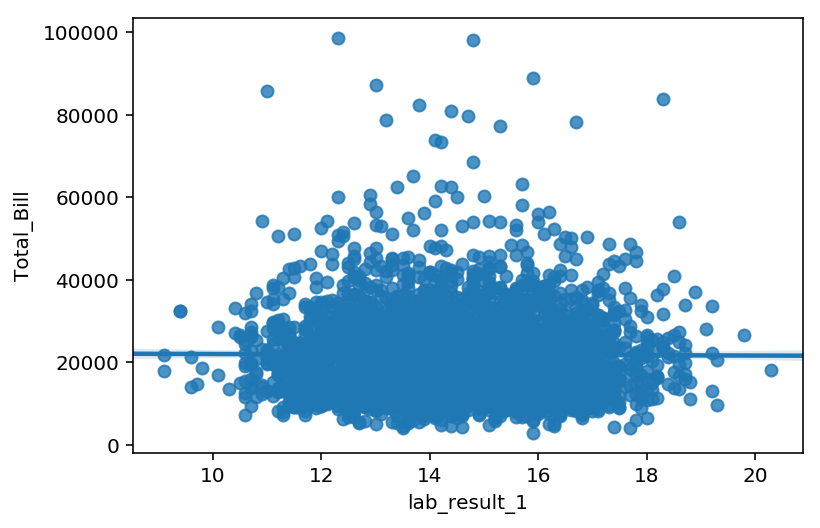

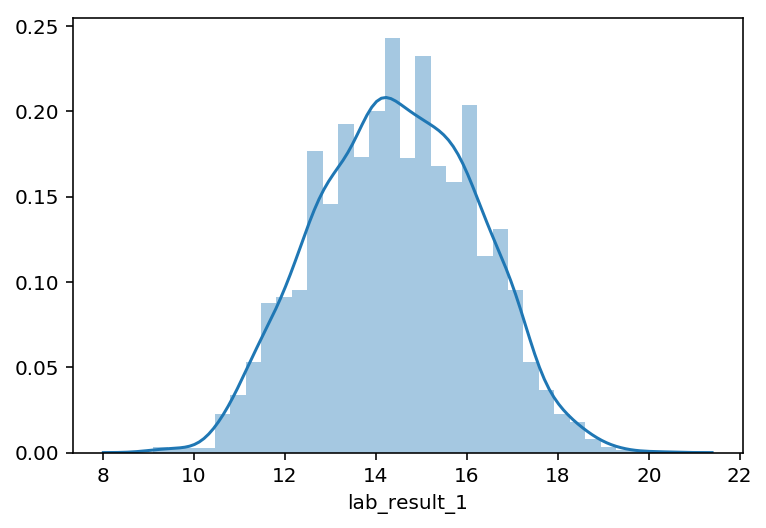

R:  -0.005536601806655936
P-value:  0.7469070381213452


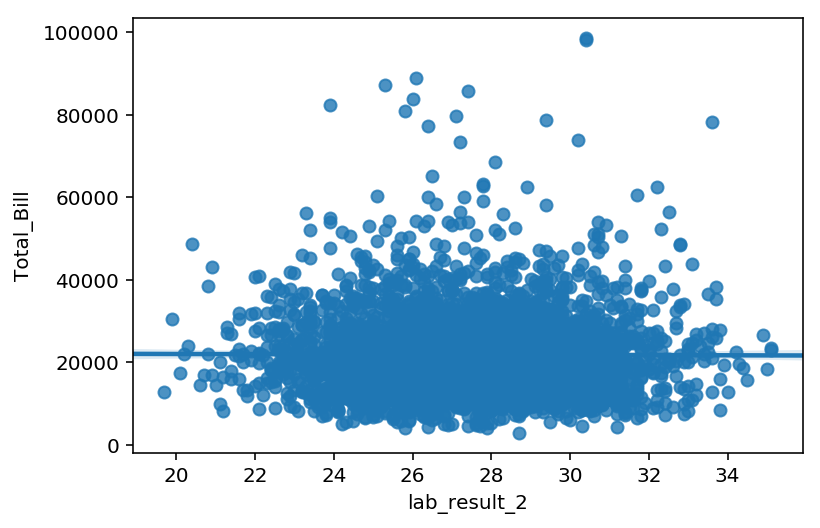

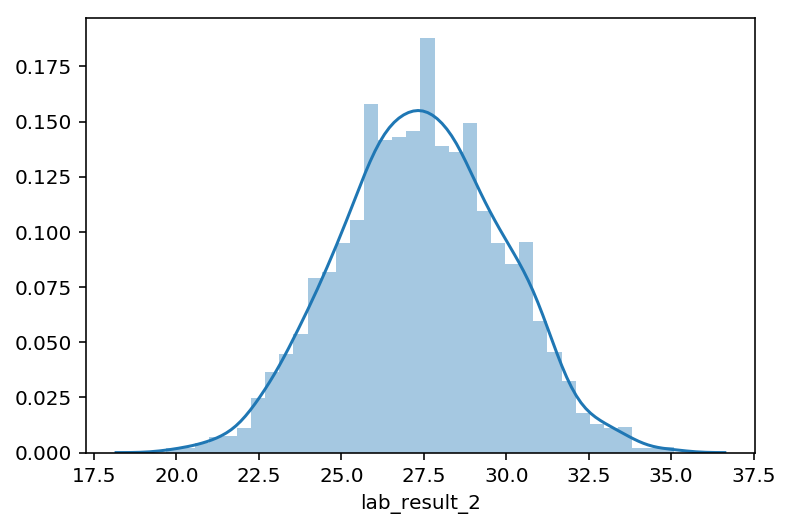

R:  9.172617878098952e-05
P-value:  0.9957340964690518


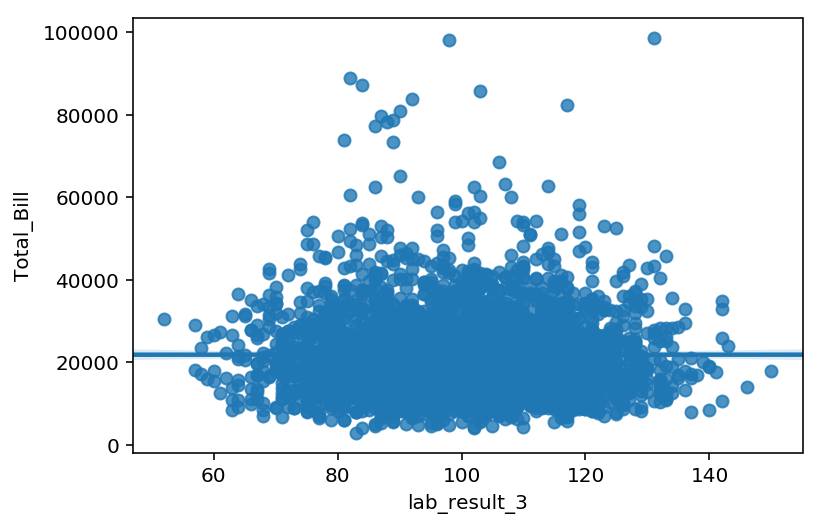

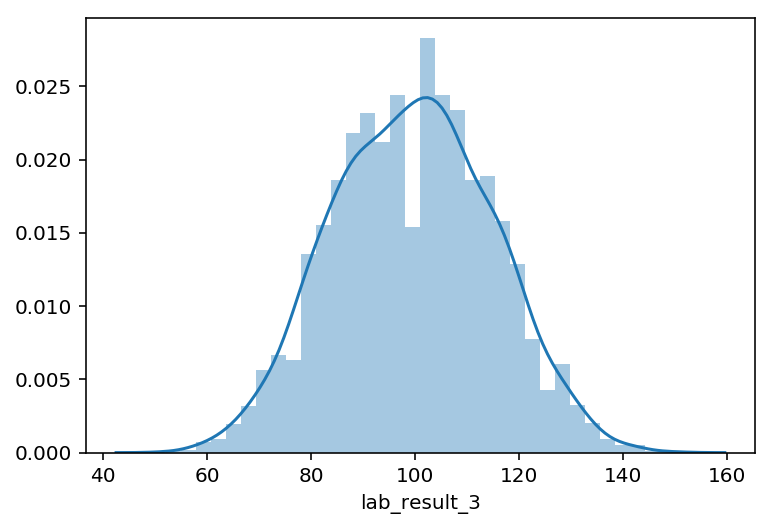

In [54]:
# Pearson Corrleation Coefficient on lab results to see if there is a linear relationship

for x in range(1,4):

    print ('R: ',stats.pearsonr(df['lab_result_'+str(x)], df['tot_bill'])[0])
    print ('P-value: ',stats.pearsonr(df['lab_result_'+str(x)], df['tot_bill'])[1])

    b = sns.regplot(df['lab_result_'+str(x)],df['tot_bill'])
    b.set_xlabel('lab_result_'+str(x),fontsize=10)
    b.set_ylabel("Total_Bill",fontsize=10)
    plt.show()
    
    sns.distplot(df['lab_result_'+str(x)])
    plt.show()